In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.metrics import mean_squared_error

In [3]:
from expertise.multical import assess_callibration_train_test
from expertise.utils import generate_side_information_data
from expertise.reconcile import compute_train_patches, evaluate_test_patches, evaluate_test_patches_with_human

## Data Setup

In [156]:
train_N = 1000
test_N = 100
x_d = 1
side_d = 1
true_predictor_weights = np.array([1,-1,0])
human_predictor_weights = np.array([0,1,0])

In [157]:
X_train, human_train, y_train, X_test, human_test, y_test = generate_side_information_data(train_N,test_N,x_d,side_d,true_predictor_weights=true_predictor_weights,human_predictor_weights=human_predictor_weights)
f_hat = LinearRegression().fit(X_train, y_train)

## Optimal Combination

In [170]:
num_divisions = 10
epsilon = 0.1
alpha = 0.1

In [171]:
X_train_augmented = np.concatenate([X_train.T, human_train.reshape(-1,1).T]).T
X_test_augmented = np.concatenate([X_test.T, human_test.reshape(-1,1).T]).T
f_hat_augmented = LinearRegression().fit(X_train_augmented, y_train)
acc_test_augmented = mean_squared_error(f_hat_augmented.predict(X_test_augmented),y_test)
acc_test_augmented

1.2589485553439653e-31

In [172]:
predictions = f_hat.predict(X_train)
cluster_edges = np.linspace(min(predictions), max(predictions), 3)
clusters_train = np.digitize(predictions, cluster_edges) - 1 
clusters_train = np.clip(clusters_train, 0, 2)
predictions = f_hat.predict(X_test)
clusters_test = np.digitize(predictions, cluster_edges) - 1 
clusters_test = np.clip(clusters_test, 0, 2)
train_df = pd.DataFrame(np.array([clusters_train,human_train,y_train]).T,columns=["cluster","human","true_y"])
test_df = pd.DataFrame(np.array([clusters_test,human_test,y_test]).T,columns=["cluster","human","true_y"])
assess_callibration_train_test(train_df,test_df,"human","cluster","true_y")

0.020376967444511992

In [176]:
y_divisions = [(-10,10)]
human_model = LinearRegression().fit(X_train,human_train)
human_predictions = human_model.predict(X_train)
patches = compute_train_patches(X_train,human_predictions,y_train,f_hat,epsilon,alpha,y_divisions)
evaluate_test_patches(X_train,X_test,human_test,y_test,f_hat,patches)


0.20772230840999895

In [175]:
y_divisions = np.linspace(np.min(y_train),np.max(y_train),num_divisions)
y_divisions = [(y_divisions[i],y_divisions[i+1]-0.001) for i in range(len(y_divisions)-1)]
patches = compute_train_patches(X_train,human_train,y_train,f_hat,epsilon,alpha,y_divisions)
evaluate_test_patches_with_human(X_train,human_train,X_test,human_test,y_test,f_hat,patches)

0.07913322737243528

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr0/home/naveenr/miniconda3/envs/food/lib/python3.

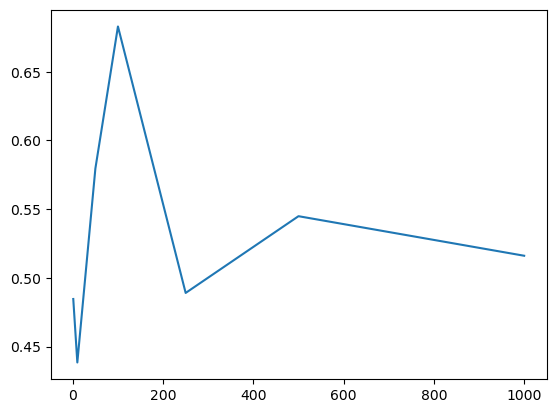

In [ ]:
x_vals = [1,10,50,100,250,500,1000]
y_vals = []
for train_N in x_vals:
    X_train, human_train, y_train, X_test, human_test, y_test = generate_side_information_data(train_N,test_N,x_d,side_d,true_predictor_weights=true_predictor_weights,human_predictor_weights=human_predictor_weights)
    f_hat = LinearRegression().fit(X_train, y_train)
    y_divisions = np.linspace(np.min(y_train),np.max(y_train),num_divisions)
    y_divisions = [(y_divisions[i],y_divisions[i+1]-0.001) for i in range(len(y_divisions)-1)]
    patches = compute_train_patches(X_train,human_train,y_train,f_hat,epsilon,alpha,y_divisions)
    y_vals.append(evaluate_test_patches_with_human(X_train,human_train,X_test,human_test,y_test,f_hat,patches))
plt.plot(x_vals,y_vals)